In [25]:
%matplotlib inline
import brian2 as b2
from brian2 import *
import numpy as np

In [26]:
set_device('cpp_standalone')

In [27]:
imgs_path = '/home/fabio/Documents/Imperial/FYP/imgs/'

In [28]:
# INFO FROM PAPER
# coupled all to all
# NO refractory period

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    show()


In [29]:
def nice_plot(sp_m, st_m, neuron_idxs, plot_voltages=True):

    fig, ax = plt.subplots(4, figsize=(8, 20), sharex=True)

    ax[0].plot(sp_m.t / ms, sp_m.i, '.k', ms=3)

    if plot_voltages:
        for i in neuron_idxs:
            ax[1].plot(st_m.t / ms, st_m.V[i] / mV, label="Neuron " + str(i))

    ax[0].set_ylabel("cells")
    
    ax[1].legend(loc="upper right")
    ax[1].set_ylabel("Voltages")
    
    ax[2].plot(st_m.t / ms, st_m.s[neuron_idxs].T / mV, lw=1, ls="--")
    ax[2].set_ylabel("s")

    ax[3].plot(st_m.t / ms, st_m.I_syn[neuron_idxs].T / mV, lw=1, ls="--")
    ax[3].set_ylabel("I_syn")
    ax[3].set_xlabel("time (ms)")
    
    plt.show()

In [30]:
# Parameters
N         =     128                           # number of neurons
gl        =     0.1   *    mS / cm**2         # conductance of the voltage-independent leak current
Vl        =     -60   *       mV              # reversal potential of the voltage-independent leak current
C         =       1   *  ufarad / cm**2       # membrane capacitance
tau       =      10   *       ms          
theta     =     -40   *       mV              # membrane potential threshold
tau1      =       3   *       ms              
tau2      =       1   *       ms    
I0        =     2.3   *     uA / cm**2        # I0 / C -> get 2.3 kHz, time that by tau to get 23 mvolts. 

# FOR INITIAL CONDITION 
# T = -tau * log((tau/second * I0 - theta) / (tau/second * I0 - Vl)) # FROM PREPRINT PAPER
T = -tau * log(1 - gl/I0 * (theta - Vl)) # FROM FINAL PAPER
c = 0.9

In [31]:
# Assuming time was measured in ms and dimensionless (in paper)
# we assume that time is not dimensionless and when dimensions don't
# match multiply/divide by ms.

In [48]:
def simulation(dt, rt, I_syn_bar_magnitude, method = 'euler'):
    start_scope()
    device.reinit()
    device.activate()
    I_syn_bar = I_syn_bar_magnitude * uA / cm**2
    k = 1 / tau2
   # k = 100 / tau1 # should be 1 / tau2 but 100/tau1 gives the right shape for 1 Neuron!

    eqs = '''
    dV/dt = (-gl * (V - Vl) + I_syn + I0) / C : volt
    I_syn = (I_syn_bar / N) * f *10 * ms     : amp / metre**2
    df/dt = (k * s - f) / tau1                : 1 / second
    ds/dt = -s / tau2                         : 1
    '''

    defaultclock.dt = dt * ms
    runtime = rt * ms

    ########### NEURONS #######################
    G = NeuronGroup(N, eqs, threshold='V > theta', reset='V = Vl', method=method, name = 'G')

    G.V = -60 * mV
    G.s = 1
    
    ########### SYNAPSES #######################    
    S = Synapses(G, G, on_pre= "s += 1", name = 'S')

    ## Connect
    S.connect(condition='i!=j')

    # INIT.
    G.V = ''' Vl + I0 / gl * (1 - exp(-c * (i * T) / (N * tau))) '''
#     for idx in range(N):
#         #curr_V0 = tau/second * I0 + (Vl - (tau/second) * I0) * exp((-c * idx * T) / (N * tau)) # FROM PREPRINT PAPER
#         curr_V0 = Vl + I0 / gl * (1 - exp(-c * (idx * T) / (N * tau))) # FROM FINAL PAPER
#         G.V[idx] = curr_V0


    # MONITORS

    sp_m = b2.SpikeMonitor(G, name='sp_m') # SPIKE 
    st_m = b2.StateMonitor(G,["V", "I_syn", "s"], record=True, name = 'st_m') # STATE

    net = b2.Network(G)
    net.add(sp_m)
    net.add(S)
    net.add(st_m)
    
    b2.run(runtime)

    return sp_m, st_m


In [49]:
def sync_measure(V):
    # Initialise lists.
    v_i_squared = np.square(V)
    avg_potentials = np.mean(V, axis = 0)

    # Compute delta_n
    squared_potentials = np.square(avg_potentials)
    delta_n = np.mean(squared_potentials) - np.square(np.mean(avg_potentials))
    
    # Compute delta
    mean_v_i_squared = np.square(np.mean(V, axis = 1))
    delta = np.mean(np.mean(v_i_squared, axis = 1) - mean_v_i_squared)
    
    # Compute sigma_n
    sigma_n = delta_n / delta 
    return sigma_n

  0%|          | 0/50 [00:00<?, ?it/s]

Starting simulation for dt = 0.25


  0%|          | 0/50 [00:00<?, ?it/s]

Starting simulation for dt = 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Starting simulation for dt = 0.01


100%|██████████| 50/50 [1:16:32<00:00, 91.84s/it] 


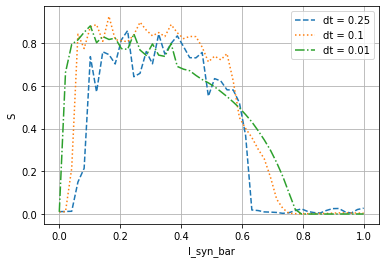

In [55]:
import datetime
import time
from tqdm import tqdm

density = 50
I_syn_bars = numpy.linspace(0, 1, num = density)
dts = [0.25, 0.1, 0.01]
styles = ['--', ':', '-.']
rt = 10000


# start_time = time.time()
# exact_start = datetime.datetime.now()
for dt, s in zip(dts, styles):
#     print('Starting simulation for dt = ' + str(dt))
    coherences = []
    for i_bar in tqdm(I_syn_bars):
        sp_m, st_m = simulation(dt, rt, i_bar, method='euler')

        # FROM PAPER: coherences analysed between 5 and 10s in a 10s simulation and 
        # sampled every millisecond.
        time_range = range(int(st_m.t.shape[0] / 2), st_m.t.shape[0], int(1 / dt))

        V_arr = np.array(st_m.V[:, time_range])
        sigma = sync_measure(V_arr)

        coherences.append(sigma)

    # Plot results.
    plt.plot(I_syn_bars, coherences, s, label = 'dt = ' + str(dt))
    
plt.xlabel('I_syn_bar')
plt.ylabel('S')
plt.grid('on')
plt.legend()
# plt.show()

plt.savefig(imgs_path + 'coherences.pdf')

# neuron_idxs = [10 * x for x in range(0, 11)]
# nice_plot(sp_m, st_m, neuron_idxs)